Загрузим все данные

In [2]:
import pandas as pd

train = pd.read_csv("data/train.csv")
train_labels = pd.read_csv("data/train_labels.csv")
test = pd.read_csv("data/test.csv")

print("Train shape:", train.shape)
print("Train labels shape:", train_labels.shape)
print("Test shape:", test.shape)


Train shape: (26296946, 20)
Train labels shape: (424116, 2)
Test shape: (3728, 21)


Здесь я достаю сессию и вопрос из targetов и добавляю отдельной колонкой 

In [3]:
train_labels['session'] = train_labels.session_id.apply(lambda x: int(x.split('_')[0]) )
train_labels['q'] = train_labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
train_labels

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


In [4]:
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


C:\Users\Ivan\AppData\Local\Temp\ipykernel_7360\1946576356.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_labels, x='q', y='correct', estimator=lambda x: sum(x)/len(x), palette='coolwarm')


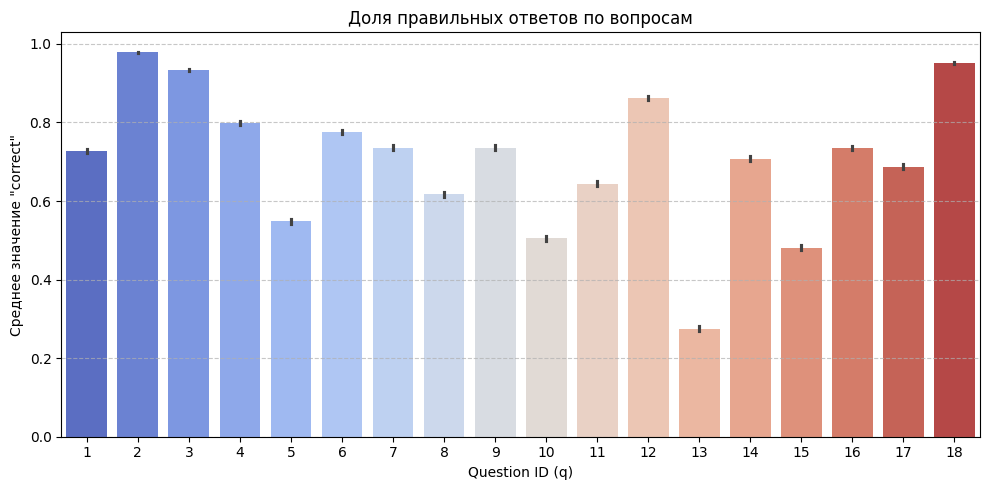

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=train_labels, x='q', y='correct', estimator=lambda x: sum(x)/len(x), palette='coolwarm')
plt.title('Доля правильных ответов по вопросам')
plt.xlabel('Question ID (q)')
plt.ylabel('Среднее значение "correct"')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Смотря на график, данные распределены не очень хорошо. Преобладание правильных ответов над направильными почти во всех вопросах

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [7]:
categorical_cols = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
numerical_cols = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

Я агрегирую категориальные признаки как число уникальных значений, а числовые — через среднее и стандартное отклонение по сессии и level_group

In [8]:
def feature_engineer(dataset_df, categorical_cols, numerical_cols):
    agg_list = []

    for col in categorical_cols:
        tmp = dataset_df.groupby(['session_id', 'level_group'])[col].nunique()
        tmp.name = f'{col}_nunique'
        agg_list.append(tmp)

    for col in numerical_cols:
        tmp = dataset_df.groupby(['session_id', 'level_group'])[col].mean()
        tmp.name = f'{col}_mean'
        agg_list.append(tmp)

    for col in numerical_cols:
        tmp = dataset_df.groupby(['session_id', 'level_group'])[col].std()
        tmp.name = f'{col}_std'
        agg_list.append(tmp)

    agg_df = pd.concat(agg_list, axis=1).fillna(-1).reset_index()

    agg_df.set_index('session_id', inplace=True)
    agg_df = agg_df.reset_index()

    return agg_df


In [9]:
features_df = feature_engineer(train, categorical_cols, numerical_cols)

In [10]:
features_df.head()

,session_id,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time_mean,level_mean,page_mean,...,screen_coor_y_mean,hover_duration_mean,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
0,20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,...,383.044872,2389.500000,49246.539458,1.230975,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757
1,20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,...,379.301020,899.925926,126666.129584,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265
2,20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,...,378.784906,969.333333,80175.676658,2.096919,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315
3,20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,...,370.723077,1378.750000,67372.714092,1.232616,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406
4,20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,...,387.930077,720.384921,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


Получение данных только по конкретному вопросу. Level_group дает нам группу вопроса

In [11]:
def get_data_for_question(q_no, features_df, labels_df):
    if q_no <= 5:
        grp = '0-4'
    elif q_no <= 13:
        grp = '5-12'
    else:
        grp = '13-22'

    X = features_df[features_df['level_group'] == grp].copy()

    sessions = X['session_id'].values

    y_df = labels_df[(labels_df['q'] == q_no) & (labels_df['session'].isin(sessions))]

    # Объединяем фичи и метки по session_id
    data = X.merge(y_df[['session', 'correct']], left_on='session_id', right_on='session', how='inner')
    # Устанавливаем session_id как индекс
    data = data.set_index('session_id')
    y = data['correct']
    X = data.drop(columns=['correct', 'session'])
    return X, y


Здесь я решил написать обычную модель, которая не учитывает последовательность действий ученика. Выбрал я catBoost. В итоге я создаю на каждый вопрос свою модель и скармливаю ей ее данные

In [12]:
from catboost import CatBoostClassifier
cat_features = ['level_group']
models_cat = {i : CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, cat_features=cat_features, verbose=0) for i in range(1,19)}

In [13]:
for i in range(1, 19):
    X_cat, y_cat = get_data_for_question(i, features_df, train_labels)  
    models_cat[i].fit(X_cat, y_cat) # обучение моделей

In [14]:
X_cat.head()#session id здесь индекс так что модель его не учитывает

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,...,screen_coor_y_mean,hover_duration_mean,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.000000,-130.347170,...,379.301020,899.925926,126666.129584,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.100000,-30.762282,...,387.930077,720.384921,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518
20090312455206810,13-22,11,4,47,12,30,9.586433e+05,17.706044,5.230769,-58.655508,...,521.446746,1055.320000,125153.779971,2.462695,0.908083,642.936288,243.042697,395.599984,181.509084,1403.679502
20090313091715820,13-22,11,4,54,14,36,1.284812e+06,17.344196,4.000000,-117.528305,...,439.860619,1038.421053,199823.575197,2.642213,0.000000,585.545356,239.123533,286.172994,141.629809,1788.698540
20090313571836404,13-22,10,3,52,13,34,9.303076e+05,17.438776,-1.000000,-143.454121,...,377.251351,1439.666667,141807.362262,2.313383,-1.000000,595.751439,223.138105,243.399010,100.641999,2179.714645


Подбор threshhold по F1

In [15]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0, 1.01, 0.01)
best_thresholds = [0.5 for _ in range(18)]# изначально 0.5

for i, model in models_cat.items():
    X_cat, y_cat = get_data_for_question(i, features_df, train_labels)
    probs = model.predict_proba(X_cat)[:, 1]  
    f1_scores = []

    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        score = f1_score(y_cat, preds)
        f1_scores.append(score)

    best_idx = np.argmax(f1_scores)
    best_thr = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    best_thresholds[i - 1] = best_thr
    print(f"Model {i}: best threshold = {best_thr:.2f}, best F1 = {best_f1:.4f}")

print(f"\nModel average best threshold = { sum(best_thresholds)/18:.2f}")

Model 1: best threshold = 0.57, best F1 = 0.8609
Model 2: best threshold = 0.89, best F1 = 0.9934
Model 3: best threshold = 0.79, best F1 = 0.9731
Model 4: best threshold = 0.65, best F1 = 0.9050
Model 5: best threshold = 0.48, best F1 = 0.7510
Model 6: best threshold = 0.59, best F1 = 0.8910
Model 7: best threshold = 0.55, best F1 = 0.8675
Model 8: best threshold = 0.52, best F1 = 0.7941
Model 9: best threshold = 0.52, best F1 = 0.8662
Model 10: best threshold = 0.41, best F1 = 0.7220
Model 11: best threshold = 0.53, best F1 = 0.8101
Model 12: best threshold = 0.71, best F1 = 0.9370
Model 13: best threshold = 0.28, best F1 = 0.5469
Model 14: best threshold = 0.56, best F1 = 0.8551
Model 15: best threshold = 0.40, best F1 = 0.7129
Model 16: best threshold = 0.66, best F1 = 0.8686
Model 17: best threshold = 0.59, best F1 = 0.8404
Model 18: best threshold = 0.79, best F1 = 0.9817

Model average best threshold = 0.58


Оценка моделей. Изза двольно плохо распределения данных много моделей дают высокую точность. Следовательно recall в таких моделях близок к 1

In [16]:
from sklearn.metrics import accuracy_score
accs = []
for i in range(1, 19):
    X_cat, y_cat = get_data_for_question(i, features_df, train_labels)
    model = models_cat[i] 
    preds_proba = model.predict_proba(X_cat)[:, 1]  
    preds = (preds_proba > best_thresholds[i - 1]).astype(int)
    
    acc = accuracy_score(y_cat, preds)
    accs.append(acc)
    print(f"Question {i}: Accuracy = {acc:.4f}")
    
print(f"\nQuestions mean accuracy = {sum(accs)/len(accs):.4f}")

Question 1: Accuracy = 0.7732
Question 2: Accuracy = 0.9871
Question 3: Accuracy = 0.9486
Question 4: Accuracy = 0.8358
Question 5: Accuracy = 0.6726
Question 6: Accuracy = 0.8175
Question 7: Accuracy = 0.7814
Question 8: Accuracy = 0.6941
Question 9: Accuracy = 0.7777
Question 10: Accuracy = 0.6498
Question 11: Accuracy = 0.7177
Question 12: Accuracy = 0.8853
Question 13: Accuracy = 0.6807
Question 14: Accuracy = 0.7717
Question 15: Accuracy = 0.6559
Question 16: Accuracy = 0.7882
Question 17: Accuracy = 0.7496
Question 18: Accuracy = 0.9647

Questions mean accuracy = 0.7862


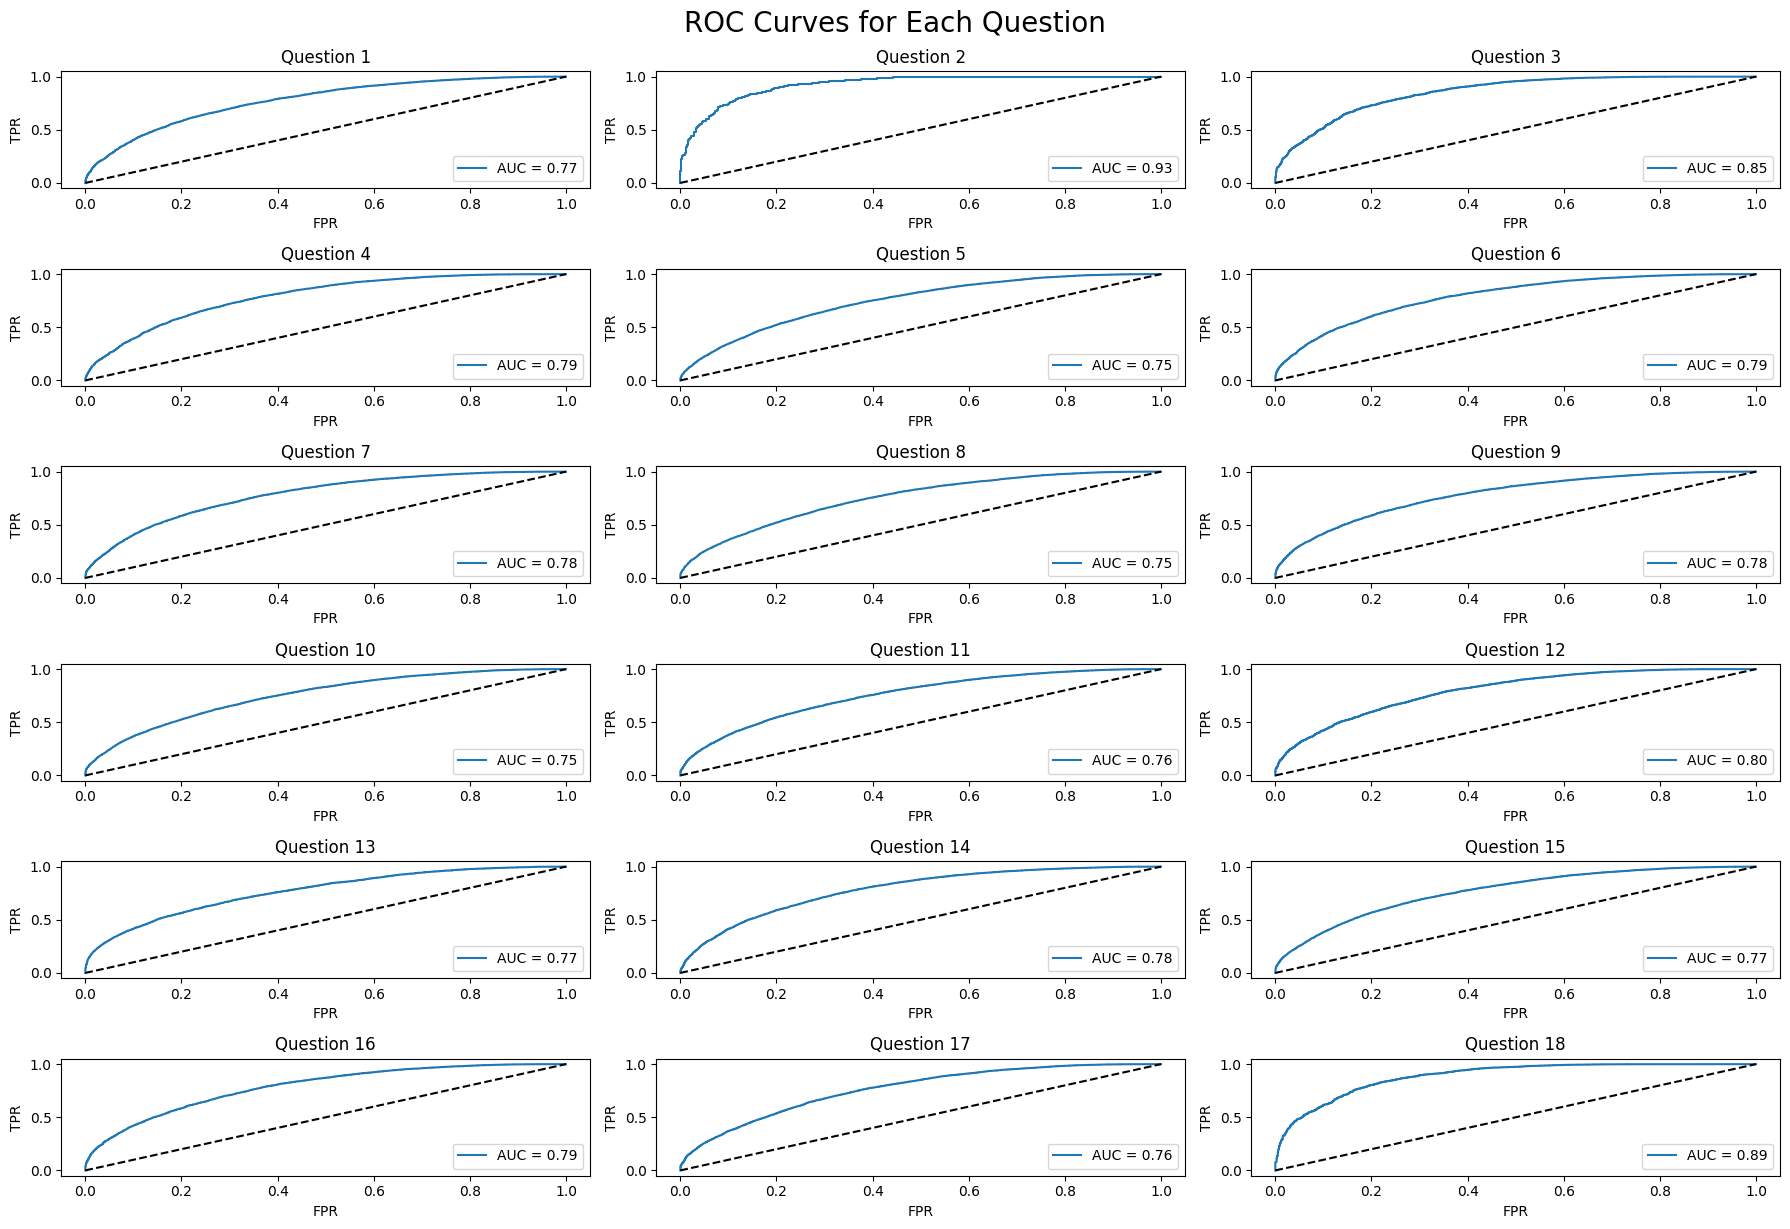

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(18, 12))
n_rows, n_cols = 6, 3  # сетка 6x3 для 18 моделей

for i, q_num in enumerate(range(1, 19), 1):
    X, y = get_data_for_question(q_num, features_df, train_labels)
    model = models_cat[q_num]
    model.fit(X, y)
    y_proba = model.predict_proba(X)[:, 1]

    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.subplot(n_rows, n_cols, i)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')  # диагональ
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Question {q_num}')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.suptitle('ROC Curves for Each Question', fontsize=20, y=1.02)
plt.show()


ЗДесь я выделяю последовательность ивентов в список а потом мерджу их с осноными агрегировнными признаками по сессия и level_group

In [17]:
event2id = {e: i+1 for i, e in enumerate(train['event_name'].unique())} 
train['event_id'] = train['event_name'].map(event2id)
event2id["padding"] = 0
grouped_sessions = train.groupby(['session_id', 'level_group'])['event_id'].apply(list)
df_sessions = grouped_sessions.reset_index(name='events')
MAX_LEN = 200

def pad_events(ev_list):
    length = len(ev_list)
    if length < MAX_LEN:
        return ev_list + [0] * (MAX_LEN - length)
    else:
        return ev_list[:MAX_LEN]

df_sessions['events'] = df_sessions['events'].apply(pad_events)



In [18]:
merged_df = df_sessions.merge(features_df, on=['session_id', 'level_group'], how='left')
merged_df.head()

,session_id,level_group,events,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time_mean,level_mean,...,screen_coor_y_mean,hover_duration_mean,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
0,20090312431273200,0-4,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 4, 3, ...",10,3,30,7,17,8.579356e+04,1.945455,...,383.044872,2389.500000,49246.539458,1.230975,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757
1,20090312431273200,13-22,"[3, 3, 3, 3, 8, 8, 8, 8, 8, 9, 3, 1, 1, 1, 1, ...",10,3,49,12,35,1.040601e+06,17.402381,...,379.301020,899.925926,126666.129584,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265
2,20090312431273200,5-12,"[3, 2, 2, 3, 3, 3, 3, 8, 9, 3, 3, 3, 3, 1, 1, ...",10,3,39,11,24,3.572052e+05,8.054054,...,378.784906,969.333333,80175.676658,2.096919,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315
3,20090312433251036,0-4,"[1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 3, 3, ...",11,4,22,6,11,9.763342e+04,1.870504,...,370.723077,1378.750000,67372.714092,1.232616,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406
4,20090312433251036,13-22,"[3, 3, 3, 3, 8, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, ...",11,6,73,16,43,2.498852e+06,17.762529,...,387.930077,720.384921,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


In [19]:
class GameDataset(Dataset):
    def __init__(self, sessions, catboost_feats, targets):
        self.sessions = sessions
        self.catboost_feats = catboost_feats
        self.targets = targets

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx):
        return (self.sessions[idx], self.catboost_feats[idx]), self.targets[idx]

Нормализую признаки через StandardScaler

In [20]:
from sklearn.preprocessing import StandardScaler
loaders_by_question = {}

for q_num in range(1, 19):
    X, y = get_data_for_question(q_num, merged_df, train_labels)
    X = X.reset_index()
    if 'level_group' in X.columns:
        X = X.drop(columns=['level_group'])
    X_seq = np.stack(X['events'].values)
    X_cat = X.drop(columns=['session_id', 'events']).values
    
    scaler = StandardScaler()
    X_cat_scaled = scaler.fit_transform(X_cat)
    X_seq_train, X_seq_val, X_cat_train, X_cat_val, y_train, y_val = train_test_split(
        X_seq, X_cat_scaled, y, test_size=0.1, random_state=42
    )
    
    X_seq_train = torch.tensor(X_seq_train, dtype=torch.long)
    X_seq_val = torch.tensor(X_seq_val, dtype=torch.long)
    X_cat_train = torch.tensor(X_cat_train, dtype=torch.float32)
    X_cat_val = torch.tensor(X_cat_val, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    y_val = torch.tensor(y_val.values, dtype=torch.float32)

    train_dataset = GameDataset(X_seq_train, X_cat_train, y_train)
    val_dataset = GameDataset(X_seq_val, X_cat_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    loaders_by_question[q_num] = (train_loader, val_loader)


In [21]:
loaders_by_question[1]

(<torch.utils.data.dataloader.DataLoader at 0x2303c008850>,
 <torch.utils.data.dataloader.DataLoader at 0x2303c009300>)

Я выбрал эту архитектуру, чтобы эффективно обрабатывать последовательности событий с помощью LSTM, которая хорошо улавливает временную зависимость. Вектор признаков сессии добавляется после LSTM, чтобы объединить информацию из событий с агрегированными статистиками для более точной классификации. Использование нескольких линейных слоев с активацией и dropout помогает улучшить обобщающую способность модели и избежать переобучения.

In [22]:
class EventLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, cat_feat_dim):
        super(EventLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + cat_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, event_seq, cat_feats):
        """
        event_seq: [batch_size, seq_len] — последовательность индексов событий
        cat_feats: [batch_size, 21] — агрегированные фичи сессии
        """
        x = self.embedding(event_seq)                # [B, T, embed_dim]
        _, (h_n, _) = self.lstm(x)                   # h_n: [1, B, hidden_dim]
        h_n = h_n.squeeze(0)                         # [B, hidden_dim]

        x_combined = torch.cat([h_n, cat_feats], dim=1)  # [B, hidden_dim + 21]
        out = self.classifier(x_combined)            # [B, 1]
        return torch.sigmoid(out).squeeze(1)         # [B]


In [32]:
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def train_model(model, train_loader, val_loader, device, n_epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.BCELoss()# loss для бинарной классификации
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for (x_seq, x_cat), y in train_loader:
            x_seq, x_cat, y = x_seq.to(device), x_cat.to(device), y.to(device).float()
            optimizer.zero_grad()
            preds = model(x_seq, x_cat)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    model.eval()    
    all_preds = []
    all_targets = []
    with torch.no_grad():
            for (x_seq, x_cat), y in val_loader:
                x_seq, x_cat = x_seq.to(device), x_cat.to(device)
                preds = model(x_seq, x_cat).cpu()
                all_preds.extend((preds > 0.5).int().tolist())
                all_targets.extend(y.tolist())

        # Metrics
    f1 = f1_score(all_targets, all_preds)
    acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)

    print(f" F1: {f1:.4f} | Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")


In [24]:
vocab_size = len(event2id)
embed_dim = 64
hidden_dim = 128
cat_feat_dim = 21
device = torch.device("cuda:0")

models = [EventLSTM(vocab_size, embed_dim, hidden_dim, cat_feat_dim).to(device) for _ in range(18)]

for i in range(18):
    
    train_loader, val_loader = loaders_by_question[i + 1]
    print(f"{i + 1}")
    train_model(models[i], train_loader, val_loader, device, n_epochs=10)


1
 F1: 0.8489 | Acc: 0.7463 | Precision: 0.7585 | Recall: 0.9639
2
 F1: 0.9912 | Acc: 0.9826 | Precision: 0.9826 | Recall: 1.0000
3
 F1: 0.9651 | Acc: 0.9325 | Precision: 0.9325 | Recall: 1.0000
4
 F1: 0.8883 | Acc: 0.7997 | Precision: 0.8045 | Recall: 0.9915
5
 F1: 0.6575 | Acc: 0.5762 | Precision: 0.5826 | Recall: 0.7545
6
 F1: 0.8769 | Acc: 0.7862 | Precision: 0.7978 | Recall: 0.9734
7
 F1: 0.8488 | Acc: 0.7416 | Precision: 0.7516 | Recall: 0.9749
8
 F1: 0.7261 | Acc: 0.6012 | Precision: 0.6214 | Recall: 0.8732
9
 F1: 0.8432 | Acc: 0.7378 | Precision: 0.7443 | Recall: 0.9725
10
 F1: 0.6137 | Acc: 0.5897 | Precision: 0.5736 | Recall: 0.6598
11
 F1: 0.7685 | Acc: 0.6462 | Precision: 0.6654 | Recall: 0.9093
12
 F1: 0.9271 | Acc: 0.8642 | Precision: 0.8660 | Recall: 0.9976
13
 F1: 0.1562 | Acc: 0.7433 | Precision: 0.5185 | Recall: 0.0920
14
 F1: 0.8350 | Acc: 0.7293 | Precision: 0.7431 | Recall: 0.9528
15
 F1: 0.5641 | Acc: 0.5986 | Precision: 0.5806 | Recall: 0.5484
16
 F1: 0.8435 | Ac

TRESHHOLD


In [25]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for (x_seq, x_cat), y in val_loader:
            x_seq = x_seq.to(device)
            x_cat = x_cat.to(device)
            y = y.to(device)

            probs = model(x_seq, x_cat)

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.linspace(0.1, 0.9, 81):
        preds_bin = (all_preds >= thresh).astype(int)
        f1 = f1_score(all_labels, preds_bin)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    return best_thresh, best_f1


In [26]:
best_thresholds = []

for i, model in enumerate(models):
    print(f"Model {i + 1}")
    _, val_loader = loaders_by_question[i + 1]  
    best_thresh, best_f1 = find_best_threshold(model, val_loader, device)
    print(f"Best threshold: {best_thresh:.3f}, F1: {best_f1:.4f}")
    best_thresholds.append(best_thresh)

print(f"Best threshold average: {sum(best_thresholds)/18:.3f}")


Model 1
Best threshold: 0.240, F1: 0.8505
Model 2
Best threshold: 0.100, F1: 0.9912
Model 3
Best threshold: 0.640, F1: 0.9653
Model 4
Best threshold: 0.100, F1: 0.8908
Model 5
Best threshold: 0.340, F1: 0.7064
Model 6
Best threshold: 0.440, F1: 0.8798
Model 7
Best threshold: 0.280, F1: 0.8535
Model 8
Best threshold: 0.350, F1: 0.7548
Model 9
Best threshold: 0.420, F1: 0.8457
Model 10
Best threshold: 0.270, F1: 0.6665
Model 11
Best threshold: 0.370, F1: 0.7849
Model 12
Best threshold: 0.100, F1: 0.9281
Model 13
Best threshold: 0.250, F1: 0.4604
Model 14
Best threshold: 0.370, F1: 0.8403
Model 15
Best threshold: 0.320, F1: 0.6664
Model 16
Best threshold: 0.450, F1: 0.8438
Model 17
Best threshold: 0.500, F1: 0.8064
Model 18
Best threshold: 0.100, F1: 0.9741
Best threshold average: 0.313


In [27]:
for i in range(18):  
    _, val_loader = loaders_by_question[i + 1]  
    models[i].eval()    
    all_preds = []
    all_targets = []
    with torch.no_grad():
                for (x_seq, x_cat), y in val_loader:
                    x_seq, x_cat = x_seq.to(device), x_cat.to(device)
                    preds = models[i](x_seq, x_cat).cpu()
                    print(preds)
                    all_preds.extend((preds > best_thresholds[i]).int().tolist())
                    all_targets.extend(y.tolist())

            # Metrics
    f1 = f1_score(all_targets, all_preds)
    acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    print(i + 1)
    print(f" F1: {f1:.4f} | Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

tensor([0.8837, 0.8079, 0.7372, 0.8376, 0.7416, 0.6961, 0.8254, 0.8325, 0.8444,
        0.8775, 0.8329, 0.6742, 0.7103, 0.7995, 0.7045, 0.5854, 0.3889, 0.5885,
        0.5822, 0.7645, 0.7729, 0.8800, 0.6641, 0.8364, 0.8796, 0.5406, 0.6049,
        0.7646, 0.8627, 0.7478, 0.7965, 0.8427, 0.8037, 0.6884, 0.8705, 0.8472,
        0.6787, 0.8123, 0.6521, 0.7718, 0.7598, 0.7077, 0.6786, 0.6846, 0.7907,
        0.8619, 0.6059, 0.7490, 0.8044, 0.6826, 0.8692, 0.6165, 0.7071, 0.8472,
        0.7718, 0.8698, 0.6851, 0.7785, 0.8845, 0.4098, 0.5091, 0.6872, 0.7511,
        0.6641])
tensor([0.6899, 0.6551, 0.8325, 0.7509, 0.7511, 0.8486, 0.8332, 0.8496, 0.7767,
        0.7664, 0.8762, 0.7531, 0.7130, 0.6435, 0.7420, 0.5571, 0.5640, 0.7916,
        0.7808, 0.8234, 0.8197, 0.6492, 0.6177, 0.4324, 0.5689, 0.6570, 0.7147,
        0.4395, 0.8850, 0.8042, 0.5940, 0.8350, 0.8899, 0.8188, 0.8487, 0.7818,
        0.6422, 0.8050, 0.8687, 0.6927, 0.8551, 0.6353, 0.7842, 0.9027, 0.8510,
        0.6538, 0.6960,

In [28]:

for i, model in enumerate(models):
    torch.save(model.state_dict(), f"models/model_{i}.pt")


In [29]:
vocab_size = 12
embed_dim = 64
hidden_dim = 128
cat_feat_dim = 21
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_models = []

for i in range(18):
    model = EventLSTM(vocab_size, embed_dim, hidden_dim, cat_feat_dim).to(device)
    model.load_state_dict(torch.load(f"models/model_{i}.pt"))
    model.eval()  # если только для инференса
    loaded_models.append(model)


In [30]:
loaded_models

[EventLSTM(
   (embedding): Embedding(12, 64)
   (lstm): LSTM(64, 128, batch_first=True)
   (classifier): Sequential(
     (0): Linear(in_features=149, out_features=128, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.3, inplace=False)
     (3): Linear(in_features=128, out_features=1, bias=True)
   )
 ),
 EventLSTM(
   (embedding): Embedding(12, 64)
   (lstm): LSTM(64, 128, batch_first=True)
   (classifier): Sequential(
     (0): Linear(in_features=149, out_features=128, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.3, inplace=False)
     (3): Linear(in_features=128, out_features=1, bias=True)
   )
 ),
 EventLSTM(
   (embedding): Embedding(12, 64)
   (lstm): LSTM(64, 128, batch_first=True)
   (classifier): Sequential(
     (0): Linear(in_features=149, out_features=128, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.3, inplace=False)
     (3): Linear(in_features=128, out_features=1, bias=True)
   )
 ),
 EventLSTM(
   (embedding): Embedding(12, 64)
   (lstm): LSTM(64, 128, batch

Пайплайн для тестоовой выборки я реализовл в отдельном ноутбуке